# March Machine Learning Mania
In this notebook, we perform EDA on the provided data via this [Kaggle competition](https://www.kaggle.com/competitions/march-machine-learning-mania-2024/overview) using the __detailed data__. With the [compact](./eda_compact.ipynb) stats, we had access to 39 men's seasons and 26 women's seasons. Using the detailed stats, this is reduced to 21 men's and 14 women's, reducing are data to almost 50% of it's original size.

In [1]:
from helper import *

# Import Data

In [2]:
# reg season DETAILED results
regresults = pd.concat([pd.read_csv(MENS_ROOT + 'MRegularSeasonDetailedResults.csv'), pd.read_csv(WOMENS_ROOT + 'WRegularSeasonDetailedResults.csv')], ignore_index=True)

# ordinals
ordinals = pd.read_csv(MENS_ROOT + 'MMasseyOrdinals.csv')

# features from eda_compact.ipynb
fcomp = pd.read_csv('data/cleaned/features_compact.csv')

# dataset names
names = ['Regular Season Results', 'Massy Ordinals']

# iterate through datasets
for data, name in zip([regresults, ordinals], names):
    # print name
    print(name)

    # show shape and nulls
    show_shape_and_nulls(data, nulls_view='print')

Regular Season Results
Shape: (200590, 34)
Null values:
Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
WFGM       0
WFGA       0
WFGM3      0
WFGA3      0
WFTM       0
WFTA       0
WOR        0
WDR        0
WAst       0
WTO        0
WStl       0
WBlk       0
WPF        0
LFGM       0
LFGA       0
LFGM3      0
LFGA3      0
LFTM       0
LFTA       0
LOR        0
LDR        0
LAst       0
LTO        0
LStl       0
LBlk       0
LPF        0
dtype: int64
Massy Ordinals
Shape: (5565793, 5)
Null values:
Season           0
RankingDayNum    0
SystemName       0
TeamID           0
OrdinalRank      0
dtype: int64


- No null values.
- We have less games with this detailed data (200K) compared to the compact data (330K).
- The Massey Ordinals dataset is massive, with over 5 million rows.

In [3]:
# iterate through datasets
for data, name in zip([regresults, ordinals], names):
    # print name
    print(name)

    # show unique values
    show_unique_vals(data)
    print('#---------------------------#', end='\n\n')

Regular Season Results
"Season" has 23 unique values

"DayNum" has 133 unique values

"WTeamID" has 737 unique values

"WScore" has 110 unique values

"LTeamID" has 737 unique values

"LScore" has 112 unique values

"WLoc" has 3 unique values
['N' 'H' 'A']

"NumOT" has 7 unique values
[0 1 2 3 4 5 6]

"WFGM" has 48 unique values

"WFGA" has 82 unique values

"WFGM3" has 28 unique values

"WFGA3" has 60 unique values

"WFTM" has 51 unique values

"WFTA" has 67 unique values

"WOR" has 40 unique values

"WDR" has 50 unique values

"WAst" has 44 unique values

"WTO" has 40 unique values

"WStl" has 35 unique values

"WBlk" has 23 unique values

"WPF" has 41 unique values

"LFGM" has 44 unique values

"LFGA" has 82 unique values

"LFGM3" has 24 unique values

"LFGA3" has 62 unique values

"LFTM" has 44 unique values

"LFTA" has 61 unique values

"LOR" has 39 unique values

"LDR" has 47 unique values

"LAst" has 34 unique values

"LTO" has 50 unique values

"LStl" has 27 unique values

"LBl

- The detailed data has many advanced metrics including shooting, assists, rebounds, turnovers, steals, blocks, and fouls committed.
- The Massey data contains day-by-day rankings of men's teams for 193 different ranking systems.

# Reshape Data

In [4]:
# view a row from regular season data
regresults.sample()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
26342,2008,75,1123,64,1185,60,H,0,22,50,2,12,18,30,14,22,12,12,9,0,20,19,44,7,19,15,21,8,22,13,14,5,2,19


Like in the compact EDA, we need to duplicate each row, where both the winning team and losing team have a team identifier.

In [5]:
# reshape data
regresults = reshape_data(regresults)

# check
print(regresults.shape)
regresults.sample()

(401180, 36)


,Season,DayNum,TeamID,Score,TeamID_opp,Score_opp,Loc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,FGM_opp,FGA_opp,FGM3_opp,FGA3_opp,FTM_opp,FTA_opp,OR_opp,DR_opp,Ast_opp,TO_opp,Stl_opp,Blk_opp,PF_opp,Loc_opp,Win
104475,2023,66,1222,87,1374,53,H,0,31,68,10,30,15,19,20,32,17,10,6,5,22,15,49,3,20,20,28,5,15,8,11,5,2,18,A,1


Each of the 200K observations has been duplicated and reshaped to represent both teams in the game.

# Aggregate Stats

In [6]:
# compute score differential for both regular season and tourney results
regresults['ScoreDiff'] = regresults['Score'] - regresults['Score_opp']

# aggregate stats
team_stats = aggregate_detailed_stats(regresults).fillna(0)

# check
print(team_stats.shape)
team_stats.sample()

(13583, 42)


,Season,TeamID,num_games,win_pct,mean_pts,std_pts,mean_pts_against,std_pts_against,mean_score_diff,std_score_diff,close_games_pct,close_games_win_pct,mean_FG2A,mean_FG3A,mean_FTA,FG2_pct,FG3_pct,FT_pct,mean_reb,std_reb,mean_reb_against,std_reb_against,mean_ast,std_ast,mean_ast_against,std_ast_against,mean_TO,std_TO,mean_TO_against,std_TO_against,mean_stl,std_stl,mean_stl_against,std_stl_against,mean_blk,std_blk,mean_blk_against,std_blk_against,mean_fouls,std_fouls,mean_fouls_against,std_fouls_against
7343,2017,3349,30,0.566667,66.2,12.172326,61.466667,11.575043,4.733333,16.477641,0.233333,0.428571,35.0,20.533333,16.733333,0.498095,0.331169,0.653386,36.033333,6.127852,34.233333,5.805368,15.466667,4.644116,11.766667,3.568863,16.666667,4.535936,15.8,4.780708,6.933333,2.875981,7.766667,3.16972,1.8,1.063501,1.933333,1.552158,17.933333,4.585835,20.433333,5.443651


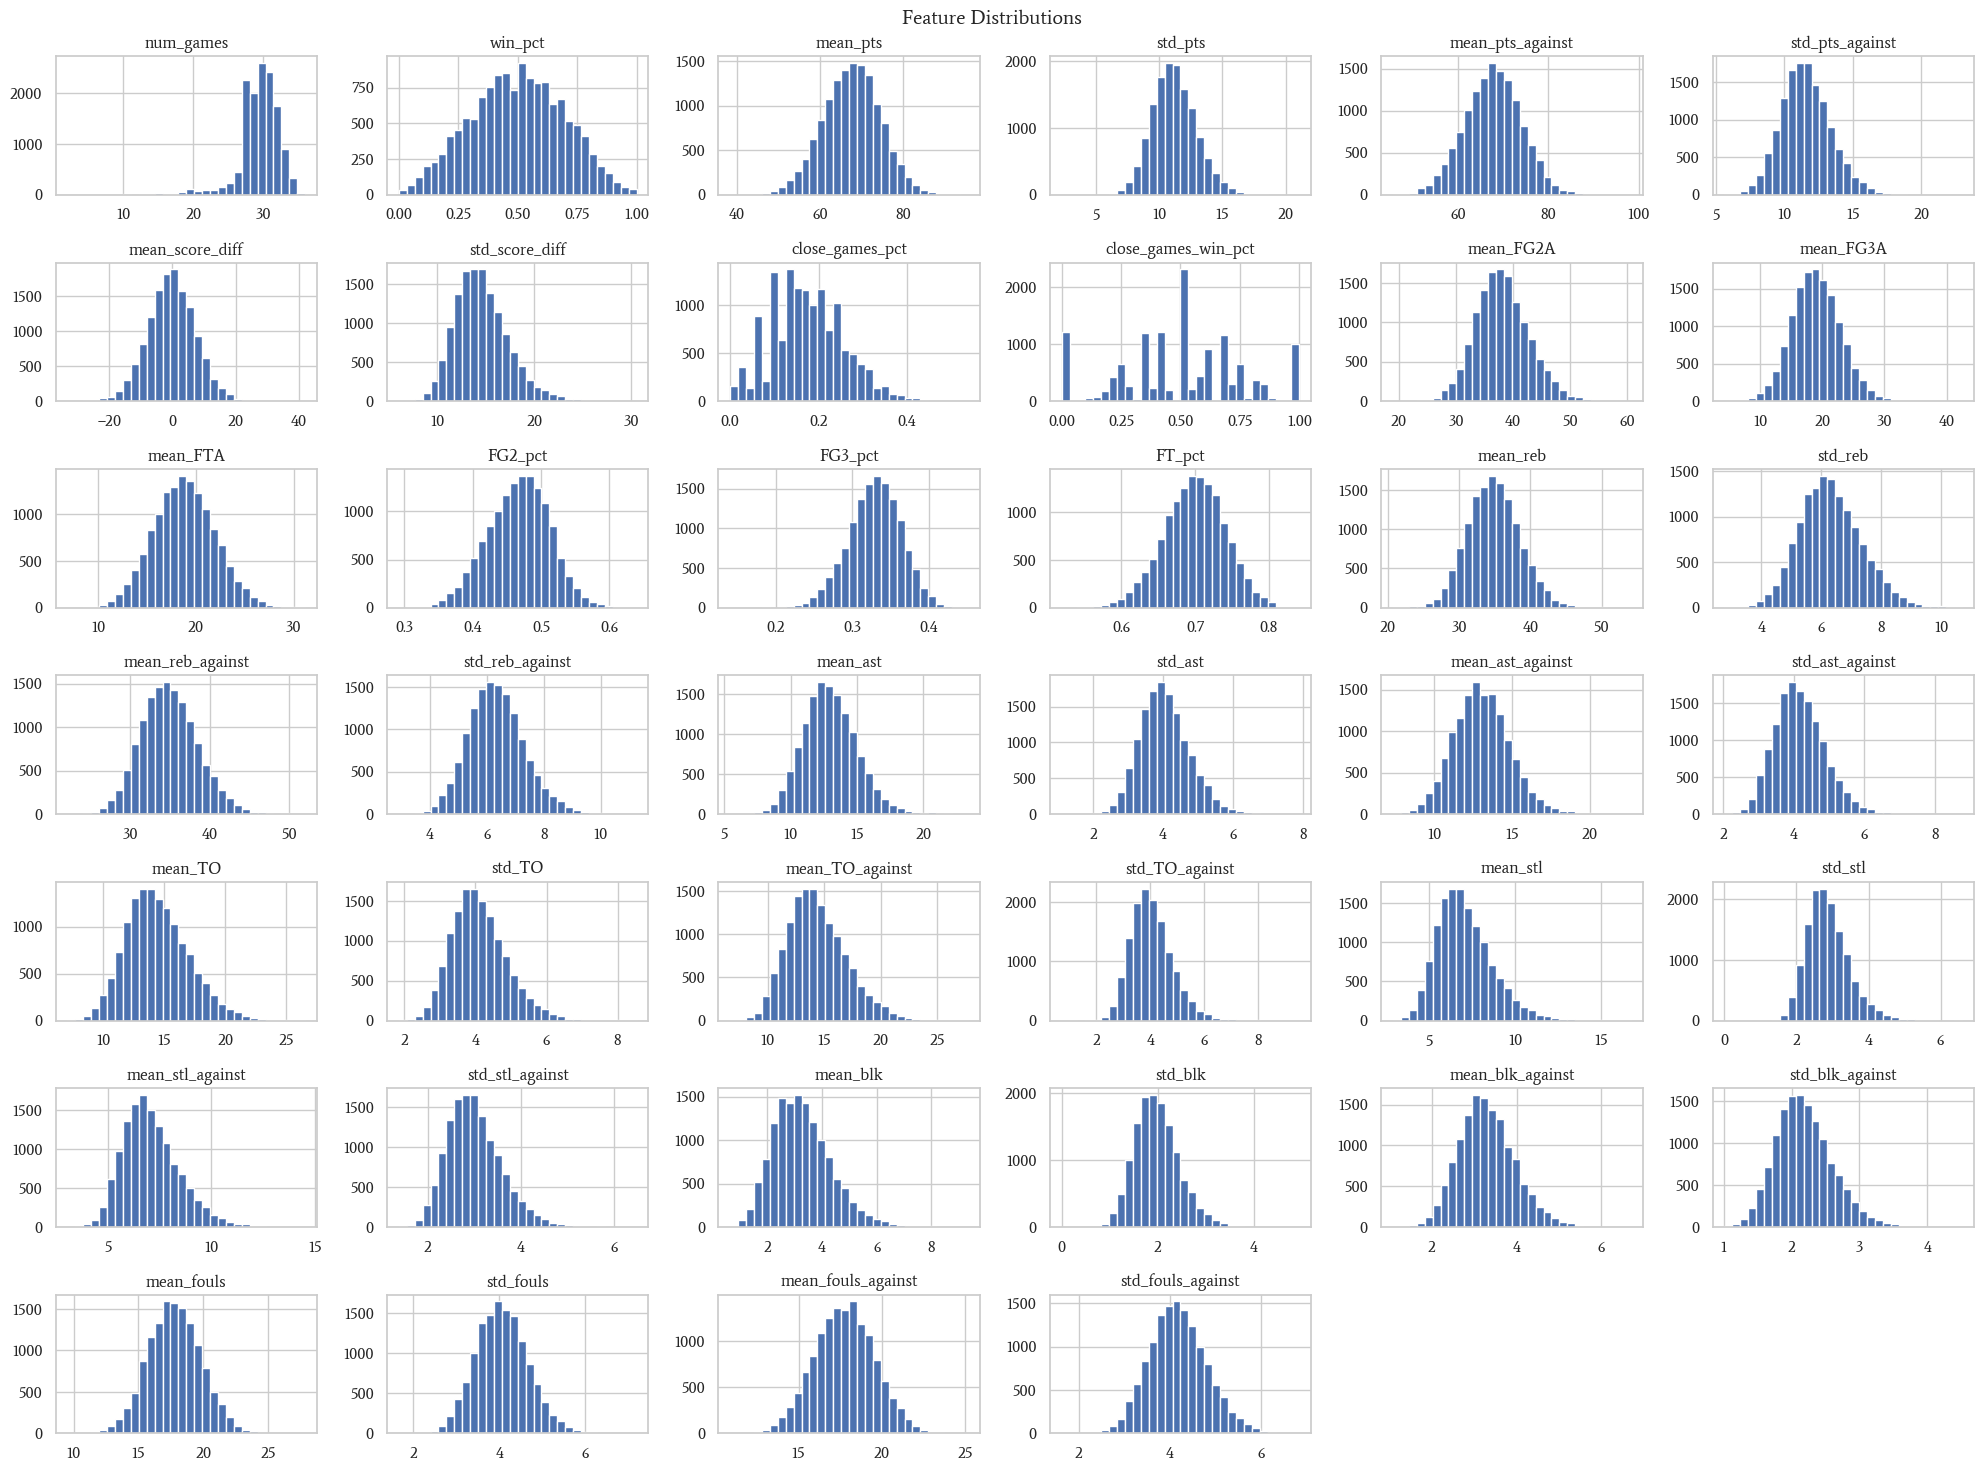

In [7]:
# plot histograms for all features (check for normality)
team_stats.iloc[:, 2:].hist(bins=30, figsize=(20, 15))
plt.suptitle('Feature Distributions')
plt.tight_layout()
plt.show()

- 37/40 distributions look relatively normal. num_games, close_games_pct, and close_games_win_pct do not.
- We'll perform a specific normality test to see if this is a reasonable assumption.

In [8]:
# create count_df to store normality results
count_df = pd.DataFrame(columns=['feature', 'statistic', 'p_value', 'normal', 'significance_level'])

# significance level (lower is less strict)
sig_level = 0.01

# iterate through features
for col in team_stats.columns[2:]:
    # get normality test results
    stat, p = normaltest(team_stats[col])

    # check if p-value is greater than significance level
    is_normal = p > sig_level

    # append results to count_df
    count_df.loc[len(count_df)] = {
        'feature': col, 
        'statistic': stat, 
        'p_value': p,
        'normal': is_normal,
        'significance_level': sig_level
    }

# look at features that passed normality test
count_df.query('normal == True')

,feature,statistic,p_value,normal,significance_level
2,mean_pts,4.518903,0.104408,True,0.01
4,mean_pts_against,9.084438,0.010650,True,0.01
38,mean_fouls_against,8.708250,0.012854,True,0.01


- Only __3/40 features were classified as normal__ (and I used a very low sig value, which is less strict).
- Thus, for this data, I will use the RobustScaler when making predictions.

# Combine with Compact Features

In [9]:
# rename fcomp columns
map = {col: col[1:] + '_x' if col.startswith('W') else (col[1:] + '_y' if col.startswith('L') else col) for col in fcomp.columns}
fcomp = fcomp.rename(columns=map)

fcomp.sample()

,Season,DayNum,TeamID_x,Score_x,Region_x,Seed_num_x,PlayIn_x,Loc_x,TeamID_y,Score_y,Region_y,Seed_num_y,PlayIn_y,NumOT,num_games_x,win_pct_x,mean_pts_x,std_pts_x,mean_pts_against_x,std_pts_against_x,mean_score_diff_x,std_score_diff_x,home_game_pct_x,away_game_pct_x,neutral_game_pct_x,home_win_pct_x,away_win_pct_x,neutral_win_pct_x,close_games_pct_x,close_games_win_pct_x,num_games_y,win_pct_y,mean_pts_y,std_pts_y,mean_pts_against_y,std_pts_against_y,mean_score_diff_y,std_score_diff_y,home_game_pct_y,away_game_pct_y,neutral_game_pct_y,home_win_pct_y,away_win_pct_y,neutral_win_pct_y,close_games_pct_y,close_games_win_pct_y,Loc_y,seed_diff_x,seed_diff_y,round,TeamName_x,TeamName_y,num_championships_x,num_championships_y
1732,2012,137,1462,67,Y,10,0,N,1323,63,Y,7,0,0,33,0.636364,70.787879,9.594131,67.454545,9.666601,3.333333,12.035538,0.484848,0.363636,0.151515,0.8125,0.416667,0.6,0.181818,0.833333,33,0.666667,66.484848,14.10922,61.515152,11.169493,4.969697,16.067212,0.515152,0.30303,0.181818,0.941176,0.5,0.166667,0.151515,0.8,N,3,-3,1,Xavier,Notre Dame,0,0


Since we already have the win & point-related aggregations (that are also contained in fcomp), we don't need to also add these columns.

In [10]:
# keep only ['Season, 'TeamID', 'Score', 'Seed_num', 'PlayIn'] (for both _x and _y)
fcomp = fcomp[['Season', 'NumOT', 'TeamID_x', 'Score_x', 'Seed_num_x', 'PlayIn_x', 'TeamID_y', 'Score_y', 'Seed_num_y', 'PlayIn_y']]

# merge fcomp with team_stats
master = fcomp.merge(
    team_stats.add_suffix('_x'), 
    how='left', 
    left_on=['Season', 'TeamID_x'],
    right_on=['Season_x', 'TeamID_x'],
).merge(
    team_stats.add_suffix('_y'), 
    how='left', 
    left_on=['Season', 'TeamID_y'], 
    right_on=['Season_y', 'TeamID_y'],
).drop(columns=['Season_x', 'Season_y'])

# drop duplicate columns
master = master.T.drop_duplicates().T

# drop rows with nulls
master = master.dropna()

# check
print(master.shape)
master.sample()

(2204, 90)


,Season,NumOT,TeamID_x,Score_x,Seed_num_x,PlayIn_x,TeamID_y,Score_y,Seed_num_y,PlayIn_y,num_games_x,win_pct_x,mean_pts_x,std_pts_x,mean_pts_against_x,std_pts_against_x,mean_score_diff_x,std_score_diff_x,close_games_pct_x,close_games_win_pct_x,mean_FG2A_x,mean_FG3A_x,mean_FTA_x,FG2_pct_x,FG3_pct_x,FT_pct_x,mean_reb_x,std_reb_x,mean_reb_against_x,std_reb_against_x,mean_ast_x,std_ast_x,mean_ast_against_x,std_ast_against_x,mean_TO_x,std_TO_x,mean_TO_against_x,std_TO_against_x,mean_stl_x,std_stl_x,mean_stl_against_x,std_stl_against_x,mean_blk_x,std_blk_x,mean_blk_against_x,std_blk_against_x,mean_fouls_x,std_fouls_x,mean_fouls_against_x,std_fouls_against_x,num_games_y,win_pct_y,mean_pts_y,std_pts_y,mean_pts_against_y,std_pts_against_y,mean_score_diff_y,std_score_diff_y,close_games_pct_y,close_games_win_pct_y,mean_FG2A_y,mean_FG3A_y,mean_FTA_y,FG2_pct_y,FG3_pct_y,FT_pct_y,mean_reb_y,std_reb_y,mean_reb_against_y,std_reb_against_y,mean_ast_y,std_ast_y,mean_ast_against_y,std_ast_against_y,mean_TO_y,std_TO_y,mean_TO_against_y,std_TO_against_y,mean_stl_y,std_stl_y,mean_stl_against_y,std_stl_against_y,mean_blk_y,std_blk_y,mean_blk_against_y,std_blk_against_y,mean_fouls_y,std_fouls_y,mean_fouls_against_y,std_fouls_against_y
3620,2016.0,0.0,3417.0,66.0,3.0,0.0,3218.0,50.0,14.0,0.0,32.0,0.75,74.40625,12.398906,64.0625,13.666388,10.34375,13.148309,0.1875,0.333333,54.0625,13.15625,20.71875,0.434682,0.330166,0.693816,42.90625,8.406447,39.4375,7.812056,13.34375,4.396548,12.8125,3.449521,14.53125,4.785626,18.28125,3.795025,9.96875,2.693892,6.6875,2.361485,4.6875,2.71718,2.5625,1.933366,18.46875,4.859207,17.59375,3.774784,31.0,0.677419,65.064516,10.016438,59.129032,11.74377,5.935484,16.14917,0.193548,0.5,40.516129,15.387097,20.516129,0.453822,0.303983,0.694969,41.83871,6.628709,31.387097,4.930703,13.16129,3.652367,9.645161,4.854883,16.967742,5.307126,12.967742,4.230712,4.612903,2.060379,7.83871,3.184303,3.16129,1.951013,2.967742,2.387242,17.870968,4.153247,19.774194,5.85212


In [11]:
# save 2025 features
features_2025_detailed = team_stats.query('Season == 2025').drop(columns='Season')
features_2025_detailed.to_csv('data/cleaned/features_2025_detailed.csv', index=False)

# save master
master.to_csv('data/cleaned/features_detailed.csv', index=False)